# **Notebook 2a**: EfficientDet

<span style="font-size: 1.5rem;">By **Michael Farrugia**</span>

## **Environment Setup**

In [21]:
INSTALL_PACKAGES = False

In [22]:
if INSTALL_PACKAGES:
    !pip install -r requirements.txt

In [23]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## **Dataset Validation**

In [24]:
import json

with open("./dataset/COCO-based_COCO/annotations/train.json", "r") as f:
    train_annotations = json.load(f)

with open("./dataset/COCO-based_COCO/annotations/val.json", "r") as f:
    val_annotations = json.load(f)

with open("./dataset/COCO-based_COCO/annotations/test.json", "r") as f:
    test_annotations = json.load(f)

print(f"Number of images in the train set: {len(train_annotations ['images'])}")
print(f"Number of images in the validation set: {len(val_annotations ['images'])}")
print(f"Number of images in the test set: {len(test_annotations ['images'])}")

Number of images in the train set: 483
Number of images in the validation set: 88
Number of images in the test set: 86


The images used in this notebook are split according to the `.json` files. To use the images in training, the `images` folder must exist - if this folder does not exist, the cell below is used to create the necessary folders according to how the dataset is split, by extracting the original images from each member's folder.

In [25]:
import os
import shutil

if not os.path.exists("./dataset/COCO-based_COCO/images/"):
    os.makedirs("./dataset/COCO-based_COCO/images/")

    for dataset, dataset_type in zip([train_annotations, val_annotations, test_annotations], ["train", "val", "test"]):
        os.makedirs(f"./dataset/COCO-based_COCO/images/{dataset_type}/")
        img_filenames = [img ["file_name"] for img in dataset ["images"]]
        
        for img_filename in img_filenames:
            member_name = img_filename.split("-") [1].split("_") [0]

            img_src_path = f"./{member_name}/images/{img_filename}"
            img_dst_path = f"./dataset/COCO-based_COCO/images/{dataset_type}/{img_filename}"
            
            shutil.copyfile(img_src_path, img_dst_path)

## **Model Setup and Configuration**

In [26]:
from effdet import get_efficientdet_config

config = get_efficientdet_config("efficientdet_d0")
config.num_classes = 6
config.image_size = (512, 512)

In [27]:
from effdet import EfficientDet

effdet_model = EfficientDet(config, pretrained_backbone = True)
effdet_model.to(device)

EfficientDet(
  (backbone): EfficientNetFeatures(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (co

The `DetBenchTrain` class is used to wrap the EfficientDet model for training. The configuration is modified to suit the dataset used in this assignment.

In [28]:
from effdet import DetBenchTrain

effdet_bench = DetBenchTrain(effdet_model, config)
effdet_bench.to(device)

DetBenchTrain(
  (model): EfficientDet(
    (backbone): EfficientNetFeatures(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): SiLU(inplace=True)
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), st

An `AdamW` optimiser is used for training, with a learning rate of `1e-4`.

In [29]:
optimiser = torch.optim.AdamW(effdet_bench.parameters(), lr = 1e-4)

Next, the `torch` dataset and dataloader are created for training and validation. This also includes defining a `train_transform` and `test_transform` function to preprocess the images and annotations for EfficientDet.

In [30]:
import albumentations as A

def train_transform():
    return A.Compose([
        A.Resize(512, 512),
        A.HorizontalFlip(p = 0.5),
        A.ShiftScaleRotate(shift_limit = 0.0625, scale_limit = 0.1, rotate_limit = 15, p = 0.5),
        A.RandomBrightnessContrast(p = 0.5),
        A.ColorJitter(p = 0.5),
        A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
        A.pytorch.ToTensorV2()
    ], bbox_params = A.BboxParams(format = "coco", label_fields = ["labels"], min_area = 0, min_visibility = 0))

def test_transform():
    return A.Compose([
        A.Resize(512, 512),
        A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
        A.pytorch.ToTensorV2()
    ], bbox_params = A.BboxParams(format = "coco", label_fields = ["labels"], min_area = 0, min_visibility = 0))

In [31]:
import cv2

class EfficientDetDataset(torch.utils.data.Dataset):
    def __init__(self, annotations, img_dir, transform = None):
        self.annotations = annotations
        self.img_dir = img_dir
        self.transform = transform

        self.img_id_to_annotations = {}
        for annotation in self.annotations ["annotations"]:
            img_id = annotation ["image_id"]
            if img_id not in self.img_id_to_annotations:
                self.img_id_to_annotations [img_id] = []
            self.img_id_to_annotations [img_id].append(annotation)

        self.imgs = {img ["id"]: img for img in self.annotations ["images"]}
        self.img_ids = list(self.imgs.keys())

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, index):
        img_id = self.img_ids [index]
        img_info = self.imgs [img_id]
        img_path = os.path.join(self.img_dir, img_info ["file_name"])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        annotations = self.img_id_to_annotations.get(img_id, [])
        
        bboxes = [annotation ["bbox"] for annotation in annotations]
        labels = [annotation ["category_id"] for annotation in annotations]

        if self.transform:
            transformed_image_result = self.transform(image = image, bboxes = bboxes, labels = labels)

            image = transformed_image_result ["image"]
            bboxes = transformed_image_result ["bboxes"]
            labels = transformed_image_result ["labels"]

        # convert COCO format (x, y, w, h) to xyxy format (x_min, y_min, x_max, y_max)
        if len(bboxes) > 0:
            bboxes_xyxy = []
            for bbox in bboxes:
                x, y, w, h = bbox
                bboxes_xyxy.append([x, y, x + w, y + h])
            
            bboxes = torch.tensor(bboxes_xyxy, dtype = torch.float32)
            labels = torch.tensor(labels, dtype = torch.int64)
        else:
            bboxes = torch.zeros((0, 4), dtype = torch.float32)
            labels = torch.zeros((0,), dtype = torch.int64)

        return image, {"boxes": bboxes, "labels": labels}

In [32]:
train_dataset = EfficientDetDataset(
    annotations = train_annotations,
    img_dir = "./dataset/COCO-based_COCO/images/train/",
    transform = train_transform()
)

val_dataset = EfficientDetDataset(
    annotations = val_annotations,
    img_dir = "./dataset/COCO-based_COCO/images/val/",
    transform = train_transform()
)

c:\Users\micha\anaconda3\envs\ARI3129\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


A collate function is also defined to handle batches with varying numbers of annotations.

In [33]:
def efficientdet_collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(images)

    max_objs = max(target ["boxes"].shape [0] for target in targets)

    padded_boxes = []
    padded_labels = []

    for target in targets:
        boxes = target ["boxes"]
        labels = target ["labels"]

        num_objs = boxes.shape [0]

        padded_box = torch.zeros((max_objs, 4), dtype = torch.float32)
        padded_label = torch.zeros((max_objs,), dtype = torch.int64)

        if num_objs > 0:
            padded_box [:num_objs, :] = boxes
            padded_label [:num_objs] = labels

        padded_boxes.append(padded_box)
        padded_labels.append(padded_label)

    padded_boxes = torch.stack(padded_boxes)
    padded_labels = torch.stack(padded_labels)

    return images, {"bbox": padded_boxes, "cls": padded_labels}

In [34]:
train_dataset_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 4,
    shuffle = True,
    collate_fn = efficientdet_collate_fn,
    num_workers = 0
)

In [35]:
val_dataset_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size = 4,
    shuffle = False,
    collate_fn = efficientdet_collate_fn,
    num_workers = 0
)

Finally, the `tensorboard` writer is initialised to log training and validation metrics during the training process.

In [ ]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("work_dirs/efficientdet_sign_type")

The cell below checks whether the dataset loaders are working correctly, by visualising some images and their corresponding bounding boxes and labels.

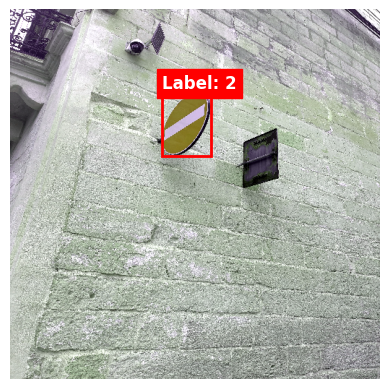

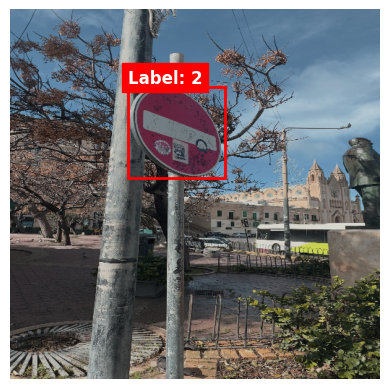

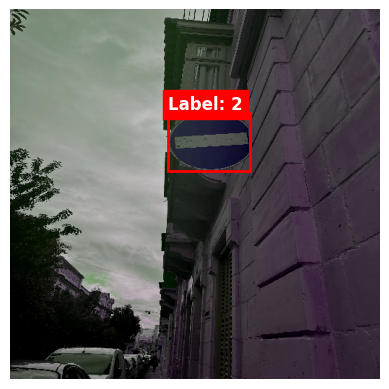

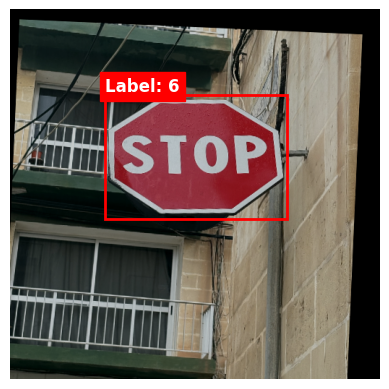

In [37]:
import matplotlib.pyplot as plt

# get first train batch for visualisation
train_images, train_targets = next(iter(train_dataset_loader))

for train_image, train_bbox, train_label in zip(train_images, train_targets ["bbox"], train_targets ["cls"]):
    img = train_image.permute(1, 2, 0)
    
    # multiply by mean and std to denormalize
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])

    plt.imshow(img)
    ax = plt.gca()

    for bbox, label in zip(train_bbox, train_label):
        if label.item() == 0:
            continue

        x_min, y_min, x_max, y_max = bbox.tolist()
        width = x_max - x_min
        height = y_max - y_min

        rect = plt.Rectangle((x_min, y_min), width, height, fill = False, color = "red", linewidth = 2)
        ax.add_patch(rect)
        ax.text(x_min, y_min - 5, f"Label: {label.item()}", color = "white", fontsize = 12, weight = "bold", backgroundcolor = "red")

    plt.axis("off")
    plt.show()

## **Model Training**

In [38]:
NUM_EPOCHS = 8

In [39]:
import time

training_start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()
    
    effdet_bench.train()
    epoch_loss = 0
    epoch_class_loss = 0
    epoch_box_loss = 0

    for batch_idx, (images, targets) in enumerate(train_dataset_loader):
        images = images.to(device)
        targets = {k: v.to(device) for k, v in targets.items()}

        optimiser.zero_grad()

        loss_dict = effdet_bench(images, targets)
        loss = loss_dict ["loss"]
        class_loss = loss_dict ["class_loss"]
        box_loss = loss_dict ["box_loss"]
        
        loss.backward()
        optimiser.step()

        epoch_loss += loss.item()
        epoch_class_loss += class_loss.item()
        epoch_box_loss += box_loss.item()

        global_step = epoch * len(train_dataset_loader) + batch_idx
        writer.add_scalar("Loss/batch", loss.item(), global_step)

    avg_loss = epoch_loss / len(train_dataset_loader)
    avg_class_loss = epoch_class_loss / len(train_dataset_loader)
    avg_box_loss = epoch_box_loss / len(train_dataset_loader)

    writer.add_scalar("Loss/train_epoch", avg_loss, epoch)
    writer.add_scalar("Loss/train_class_loss", avg_class_loss, epoch)
    writer.add_scalar("Loss/train_box_loss", avg_box_loss, epoch)
    
    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_class_loss = 0
        val_epoch_box_loss = 0

        for batch_idx, (images, targets) in enumerate(val_dataset_loader):
            images = images.to(device)
            targets = {k: v.to(device) for k, v in targets.items()}

            loss_dict = effdet_bench(images, targets)
            loss = loss_dict ["loss"]
            class_loss = loss_dict ["class_loss"]
            box_loss = loss_dict ["box_loss"]

            val_epoch_loss += loss.item()
            val_epoch_class_loss += class_loss.item()
            val_epoch_box_loss += box_loss.item()

    avg_val_loss = val_epoch_loss / len(val_dataset_loader)
    avg_val_class_loss = val_epoch_class_loss / len(val_dataset_loader)
    avg_val_box_loss = val_epoch_box_loss / len(val_dataset_loader)
    
    writer.add_scalar("Loss/val_epoch", avg_val_loss, epoch)
    writer.add_scalar("Loss/val_class_loss", avg_val_class_loss, epoch)
    writer.add_scalar("Loss/val_box_loss", avg_val_box_loss, epoch)
    
    epoch_duration = time.time() - epoch_start_time
    writer.add_scalar("Time/epoch_duration", epoch_duration, epoch)

    print(f"Epoch {epoch + 1}, Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train Class: {avg_class_loss:.4f}, Val Class: {avg_val_class_loss:.4f}, Train Box: {avg_box_loss:.4f}, Val Box: {avg_val_box_loss:.4f}, Time: {epoch_duration:.2f}s")

total_training_time = time.time() - training_start_time
writer.add_scalar("Time/total_training_time", total_training_time, 0)
print(f"\nTotal training time: {total_training_time:.2f}s ({total_training_time / 60:.2f} minutes)")

writer.close()

Epoch 1, Train Loss: 4.1373, Val Loss: 3.3556, Train Class: 1.4844, Val Class: 1.3512, Train Box: 0.0531, Val Box: 0.0401, Time: 52.81s
Epoch 2, Train Loss: 3.0124, Val Loss: 2.5713, Train Class: 1.3132, Val Class: 1.2973, Train Box: 0.0340, Val Box: 0.0255, Time: 52.85s
Epoch 3, Train Loss: 2.4306, Val Loss: 2.1455, Train Class: 1.2500, Val Class: 1.2353, Train Box: 0.0236, Val Box: 0.0182, Time: 51.62s
Epoch 4, Train Loss: 2.1814, Val Loss: 1.9794, Train Class: 1.2068, Val Class: 1.1978, Train Box: 0.0195, Val Box: 0.0156, Time: 52.22s
Epoch 5, Train Loss: 2.0827, Val Loss: 1.9068, Train Class: 1.1707, Val Class: 1.1679, Train Box: 0.0182, Val Box: 0.0148, Time: 51.81s
Epoch 6, Train Loss: 2.0265, Val Loss: 1.8309, Train Class: 1.1338, Val Class: 1.1314, Train Box: 0.0179, Val Box: 0.0140, Time: 52.14s
Epoch 7, Train Loss: 1.9162, Val Loss: 1.7500, Train Class: 1.0850, Val Class: 1.0801, Train Box: 0.0166, Val Box: 0.0134, Time: 52.09s
Epoch 8, Train Loss: 1.8765, Val Loss: 1.6637, T

### Model Saving

In [40]:
os.makedirs("./work_dirs/efficientdet_sign_type", exist_ok = True)

torch.save({
    "epoch": 10,
    "model_state_dict": effdet_model.state_dict(),
    "optimizer_state_dict": optimiser.state_dict(),
    "config": config,
}, "./work_dirs/efficientdet_sign_type/efficientdet_signd0_sign_type_final.pth")

print("Model saved to ./work_dirs/efficientdet_sign_type/efficientdet_signd0_sign_type_final.pth")

Model saved to ./work_dirs/efficientdet_sign_type/efficientdet_signd0_sign_type_final.pth


## **Model Evaluation**

The model is then evaluated on the test set, calculating metrics like Mean Average Precision (mAP), Average Precision 50 (AP50), and Average Precision 75 (AP75) to assess its performance.

In [41]:
test_dataset = EfficientDetDataset(
    annotations = test_annotations,
    img_dir = "./dataset/COCO-based_COCO/images/test/",
    transform = test_transform()
)

test_dataset_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = 4,
    shuffle = False,
    collate_fn = efficientdet_collate_fn,
    num_workers = 0
)

In [42]:
from effdet import DetBenchPredict

effdet_predict = DetBenchPredict(effdet_model)
effdet_predict.cpu()
effdet_predict.eval()

DetBenchPredict(
  (model): EfficientDet(
    (backbone): EfficientNetFeatures(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): SiLU(inplace=True)
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), 

In [43]:
from tqdm import tqdm

preds = []
targets = []

with torch.no_grad():
    for images, batch_targets in tqdm(test_dataset_loader):
        images = images.cpu()

        outputs = effdet_predict(images)

        for i in range(images.shape [0]):
            output = outputs [i]
            target_boxes = batch_targets ["bbox"] [i]
            target_labels = batch_targets ["cls"] [i]

            mask = output [:, 4] > 0.2
            valid_output = output [mask]

            pred_boxes = valid_output [:, :4].cpu()
            pred_scores = valid_output [:, 4].cpu()
            pred_labels = valid_output [:, 5].cpu().int()

            preds.append({
                "boxes": pred_boxes,
                "scores": pred_scores,
                "labels": pred_labels
            })

            valid_gt_mask = ~((target_boxes == 0).all(dim = 1))
            gt_boxes = target_boxes [valid_gt_mask].cpu()
            gt_labels = target_labels [valid_gt_mask].cpu().int()

            targets.append({
                "boxes": gt_boxes,
                "labels": gt_labels
            })

100%|██████████| 22/22 [00:12<00:00,  1.80it/s]


In [44]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

map_metric = MeanAveragePrecision(class_metrics = True)
map_metric.update(preds, targets)
results = map_metric.compute()

In [46]:
for key, value in results.items():
    print(f"{key}: {value}")

map: 0.000260784785496071
map_50: 0.0016898661851882935
map_75: 0.0
map_small: 0.0
map_medium: 0.0
map_large: 0.0004495670727919787
mar_1: 0.0
mar_10: 0.00797562301158905
mar_100: 0.00797562301158905
mar_small: 0.0
mar_medium: 0.0
mar_large: 0.009005376137793064
map_per_class: tensor([0.0000, 0.0005, 0.0000, 0.0000, 0.0000, 0.0011])
mar_100_per_class: tensor([0.0000, 0.0243, 0.0000, 0.0000, 0.0000, 0.0235])
classes: tensor([1, 2, 3, 4, 5, 6], dtype=torch.int32)
